<a href="https://colab.research.google.com/github/ZackAkil/optimising-basketball/blob/master/shot%20prediction/did_i_just_shoot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil ls gs://rugby-videos

gs://rugby-videos/VID_20181215_095232.mp4
gs://rugby-videos/deltas.joblib
gs://rugby-videos/deltas.mp4
gs://rugby-videos/output_320_full.mp4
gs://rugby-videos/y.joblib


In [2]:
!gsutil cp gs://rugby-videos/deltas.mp4 .

Copying gs://rugby-videos/deltas.mp4...
- [1 files][  6.0 MiB/  6.0 MiB]                                                
Operation completed over 1 objects/6.0 MiB.                                      


In [3]:
!gsutil cp gs://rugby-videos/y.joblib .

Copying gs://rugby-videos/y.joblib...
- [1 files][ 28.4 KiB/ 28.4 KiB]                                                
Operation completed over 1 objects/28.4 KiB.                                     


In [0]:
from sklearn.externals import joblib
from scipy.misc import imresize

In [0]:
ys = joblib.load('y.joblib')

In [0]:
!pip install scikit-video --quiet

In [0]:
from skvideo.io import vread
import numpy as np

In [0]:
M = 7000

In [0]:
X_delta = vread('deltas.mp4')[:M,:,:,0]
X = np.expand_dims(X_delta, axis=3)
del(X_delta)

In [0]:
del(X_delta)

In [6]:
X.shape

(7000, 180, 320, 1)

In [0]:
# turn y coords in to a boolean flag for 'was a shot taken'
y = ~(np.array(ys['y']) == None)[:M]

In [8]:
y.shape

(7000,)

In [0]:
import matplotlib.pyplot as plt

In [0]:
def show_random_frames(X, y):
  y_indexies, = np.where(y)
  random_ys = np.random.choice(y_indexies, 5)

  # confirm that our y match with frames with shots
  for index in random_ys:
    plt.imshow(X[index])
    plt.show()

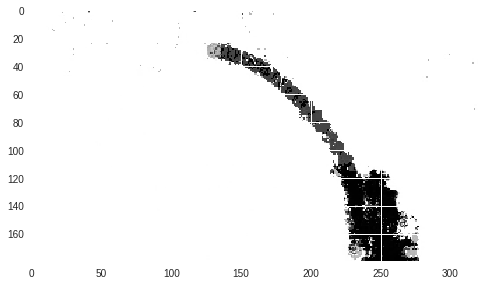

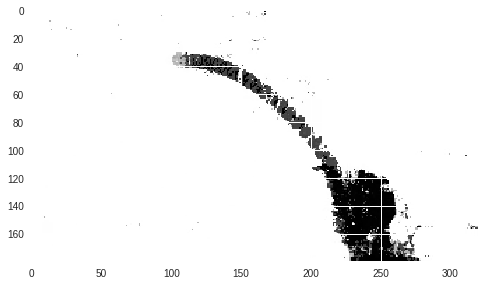

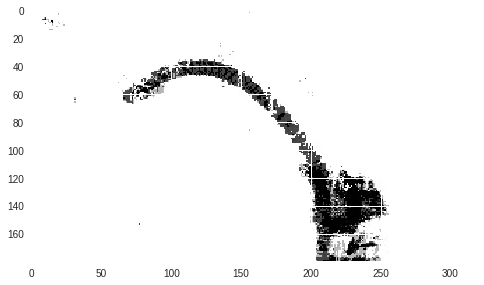

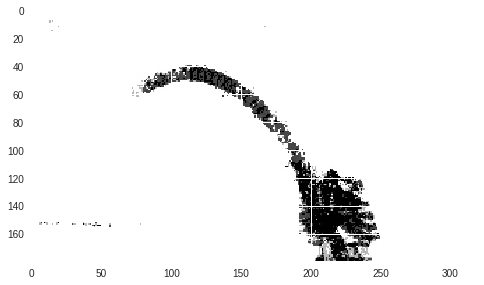

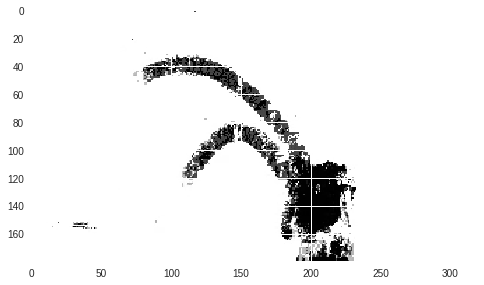

In [11]:
show_random_frames(X[:,:,:,0], y)

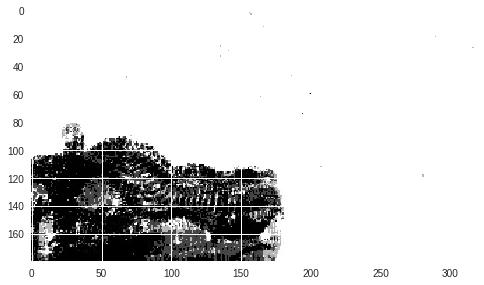

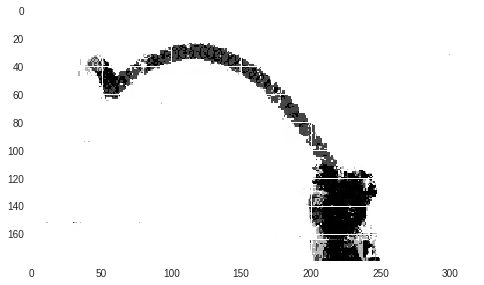

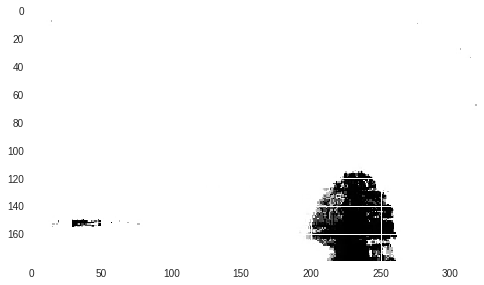

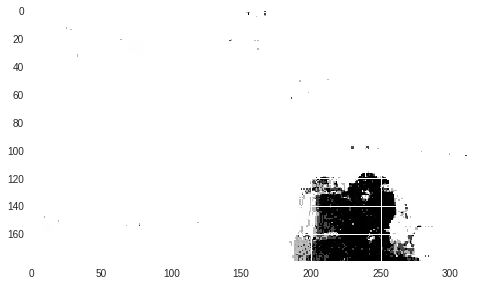

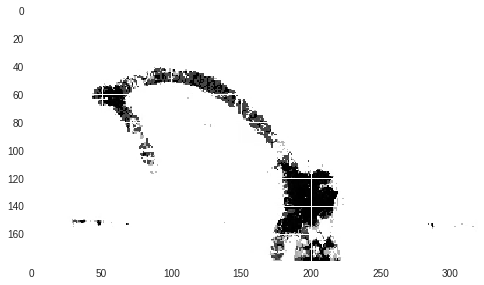

In [12]:
show_random_frames(X[:,:,:,0], ~y)

In [0]:
from sklearn.model_selection import train_test_split

In [14]:
y.shape

(7000,)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [0]:
del(X)

In [0]:
X_train = (X_train / 255.).astype(np.float16)
X_test = (X_test / 255.).astype(np.float16)

In [19]:
X_test.dtype

dtype('float64')

In [17]:
y.shape

(7000,)

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [27]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [28]:
X.shape

(7000, 180, 320, 1)

In [0]:
input_shape = (180, 320, 1)

In [0]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [34]:
batch_size = 128
epochs = 10

class_weight = {True: 10.,
                False: 1.}

model.fit(X_train, y_train,
          class_weight=class_weight,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 4690 samples, validate on 2310 samples
Epoch 1/10
4690/4690 [==============================] - 14s 3ms/step - loss: 0.1107 - acc: 0.9740 - val_loss: 0.0940 - val_acc: 0.9641
Epoch 2/10
4690/4690 [==============================] - 14s 3ms/step - loss: 0.1110 - acc: 0.9738 - val_loss: 0.1008 - val_acc: 0.9597
Epoch 3/10
4690/4690 [==============================] - 13s 3ms/step - loss: 0.1103 - acc: 0.9714 - val_loss: 0.0587 - val_acc: 0.9801
Epoch 4/10
4690/4690 [==============================] - 13s 3ms/step - loss: 0.0955 - acc: 0.9755 - val_loss: 0.0533 - val_acc: 0.9805
Epoch 5/10
4690/4690 [==============================] - 13s 3ms/step - loss: 0.0909 - acc: 0.9795 - val_loss: 0.0557 - val_acc: 0.9797
Epoch 6/10
4690/4690 [==============================] - 13s 3ms/step - loss: 0.0847 - acc: 0.9765 - val_loss: 0.0678 - val_acc: 0.9762
Epoch 7/10
4690/4690 [==============================] - 13s 3ms/step - loss: 0.0945 - acc: 0.9755 - val_loss: 0.0621 - val_acc: 0.9792
Epoch 8

In [0]:
model.predict(X_train[0:1])

array([[0.]], dtype=float32)

In [0]:
sum(y_test)/ len(y_test)

0.09438717067583047

In [0]:
np.where(y_test)

(array([  3,  17,  22,  32,  33,  40,  47,  54,  60,  64,  69,  70,  75,
         82,  85,  86,  98, 100, 105, 113, 127, 136, 155, 165, 186, 206,
        220, 222, 233, 234, 237, 243, 256, 278, 281, 300, 354, 356, 361,
        367, 380, 381, 390, 406, 419, 421, 435, 444, 445, 450, 453, 469,
        479, 481, 488, 506, 513, 527, 534, 535, 537, 539, 561, 562, 573,
        579, 580, 582, 594, 598, 601, 613, 619, 624, 651, 657]),)

In [0]:
def gray_to_channel(image):
  new_image = np.zeros([*image.shape[:2], 3])
  new_image[:,:,0] = image.reshape(image.shape[:2])
  new_image[:,:,1] = image.reshape(image.shape[:2])
  new_image[:,:,2] = image.reshape(image.shape[:2])
  return new_image

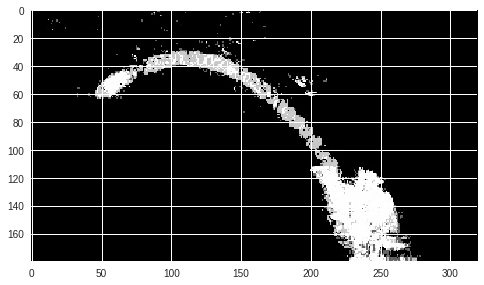

In [0]:
plt.imshow(gray_to_channel(X_test[419]))

In [0]:
[*X_test[419].shape[:2], 3]

[180, 320, 3]

In [0]:
pred, = model.predict(X_test[419:420])

In [38]:
pred[0]

8.814166e-13

In [0]:
test = X / 255.

In [0]:
output = model.predict(test)

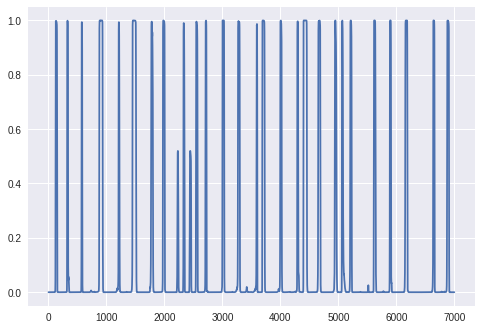

In [34]:
plt.plot(output)

In [0]:
2000/30

66.66666666666667

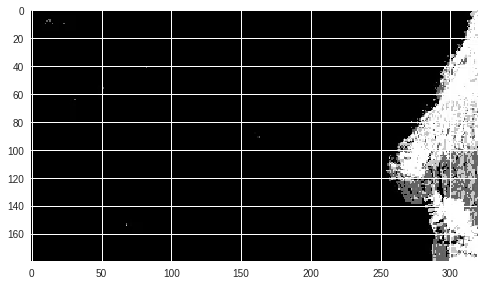

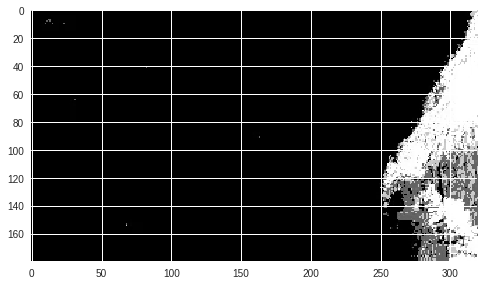

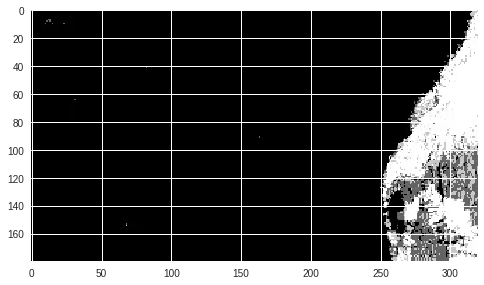

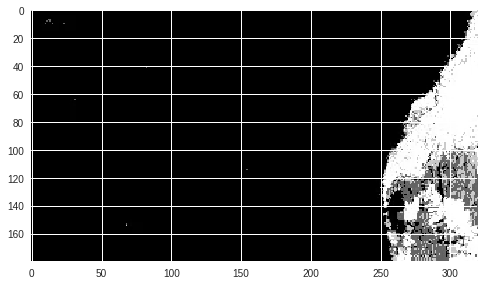

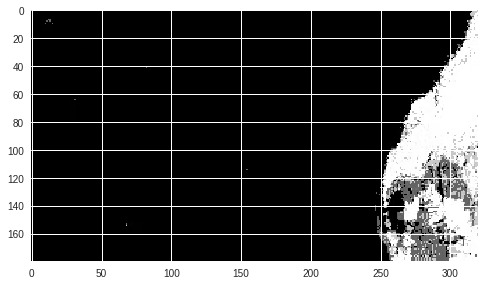

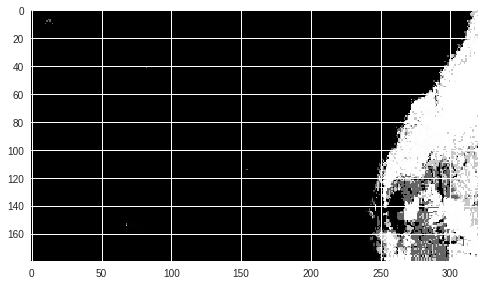

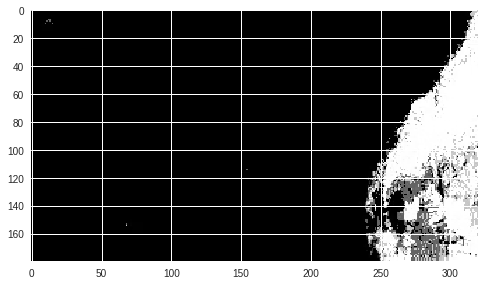

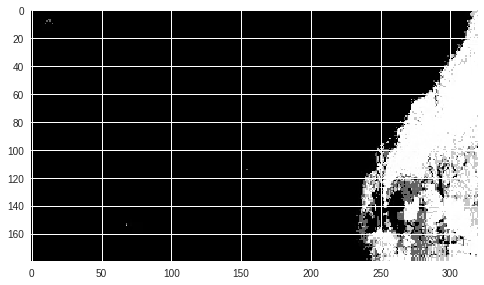

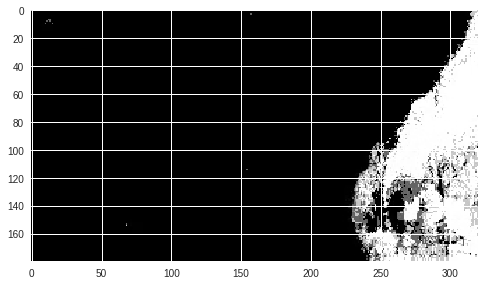

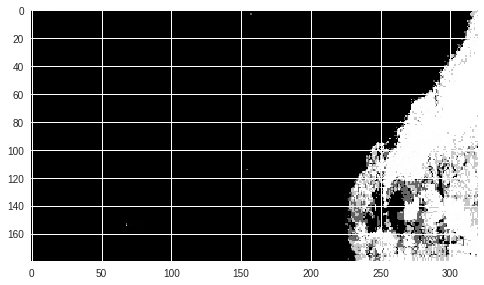

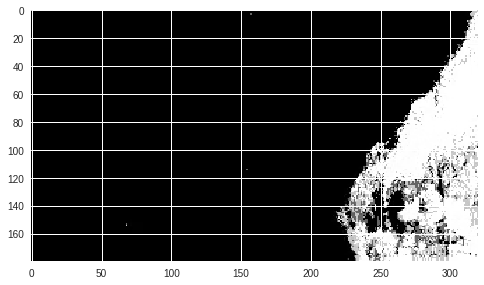

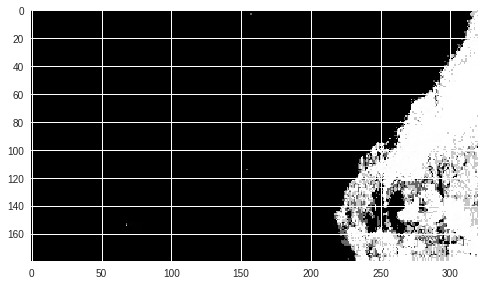

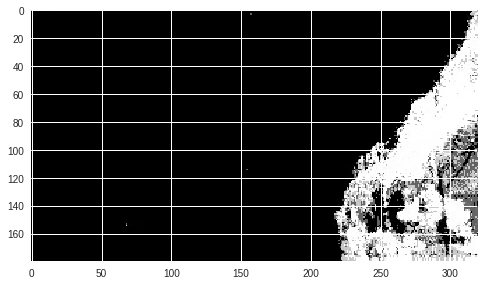

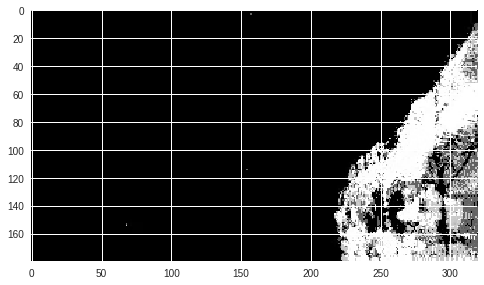

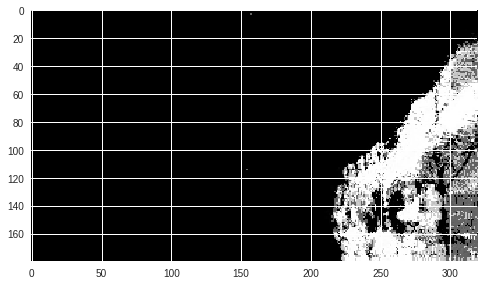

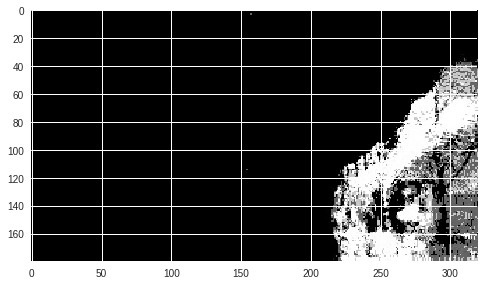

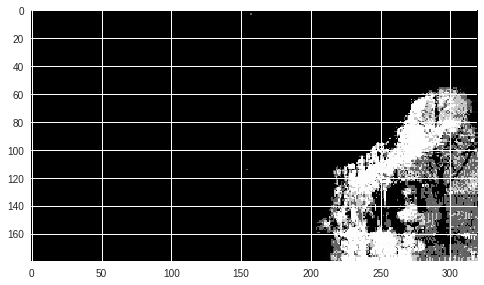

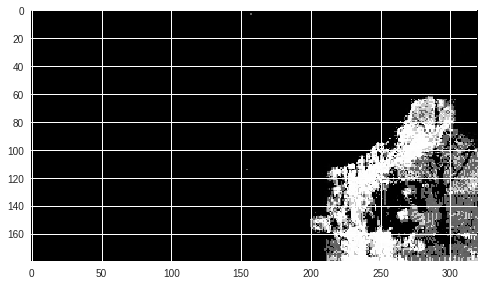

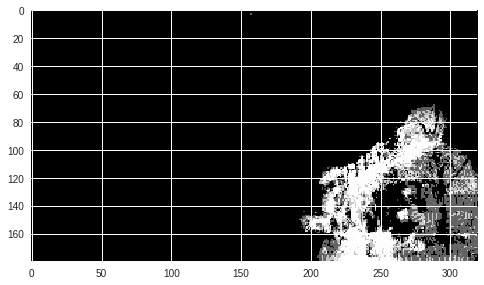

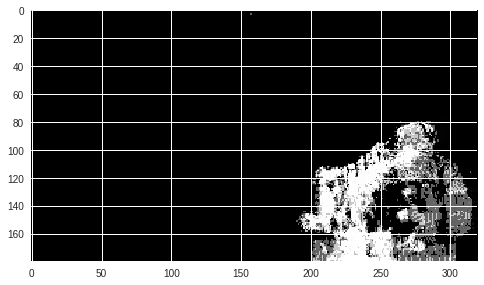

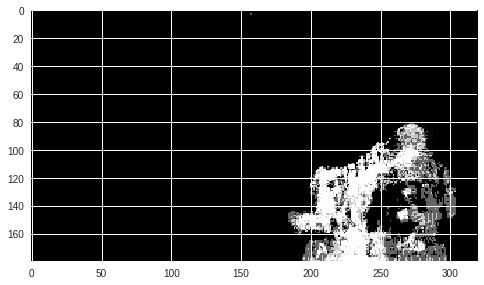

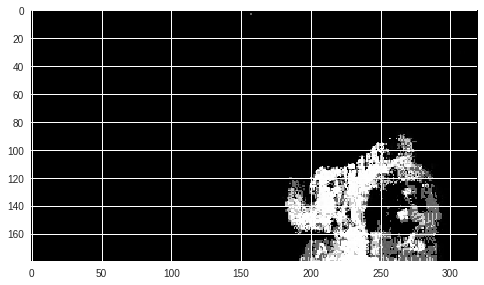

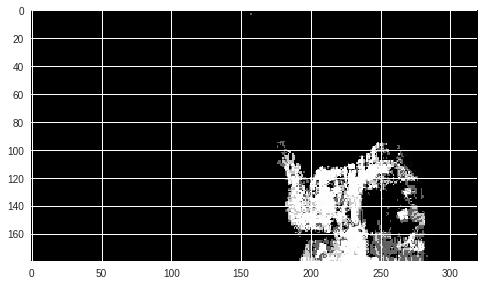

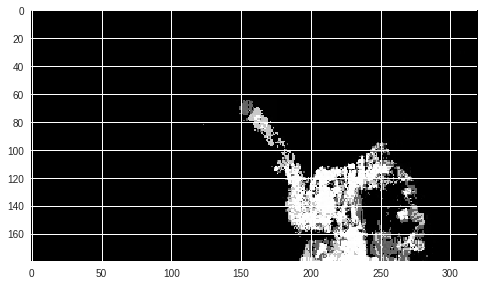

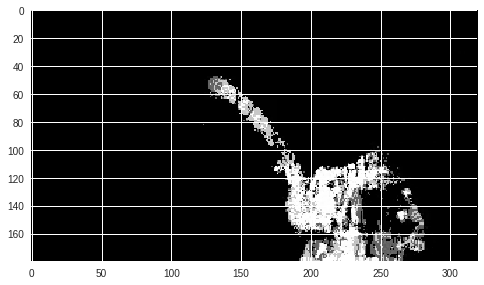

shootiing


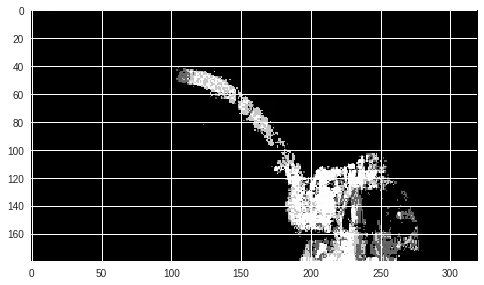

shootiing


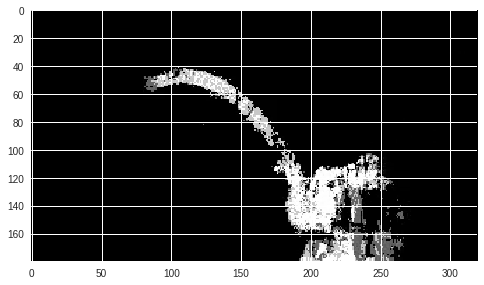

shootiing


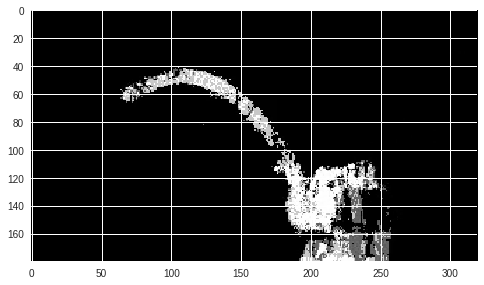

shootiing


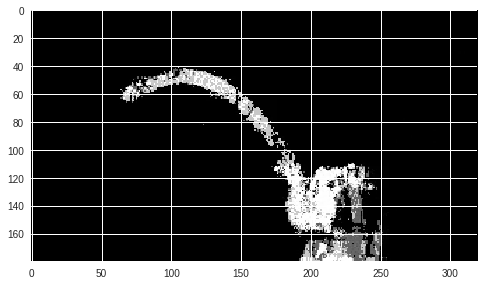

shootiing


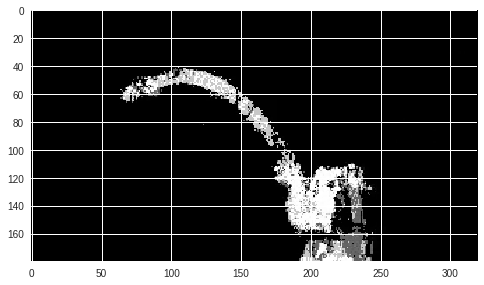

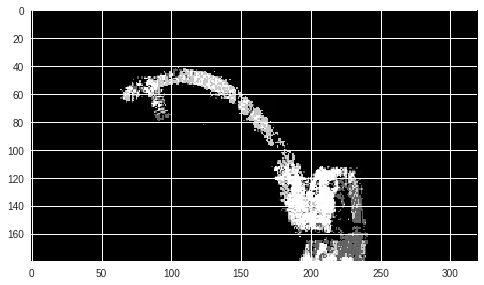

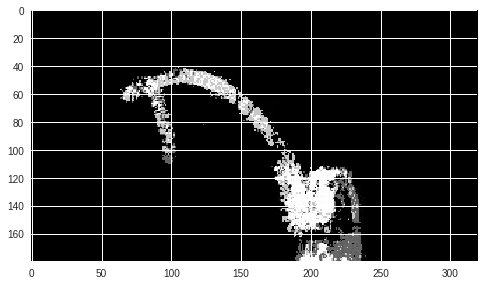

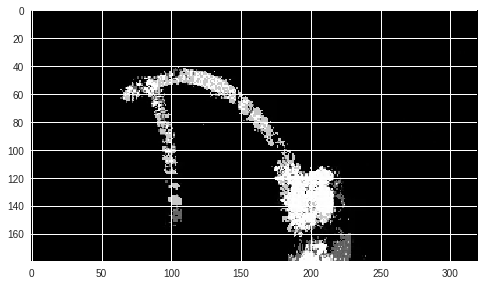

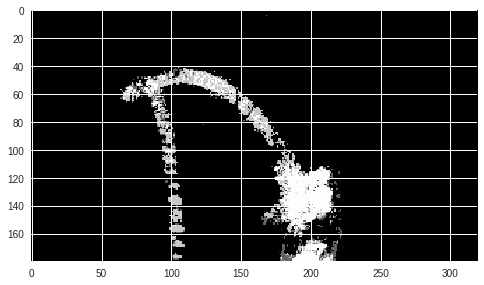

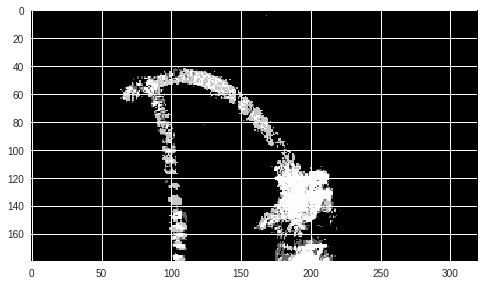

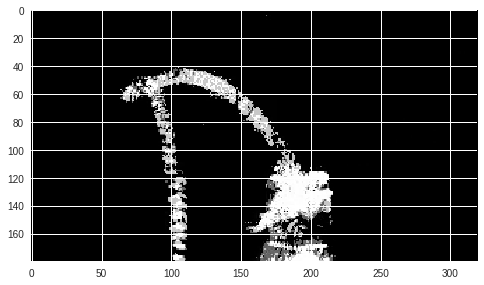

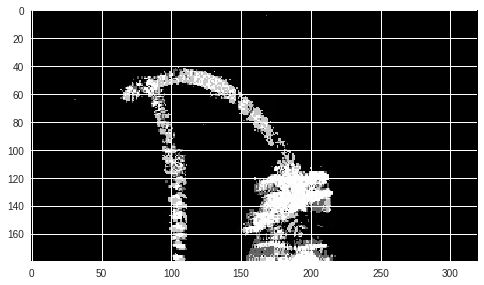

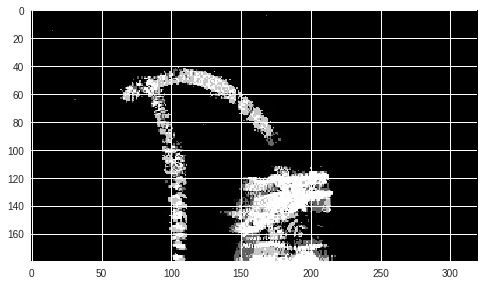

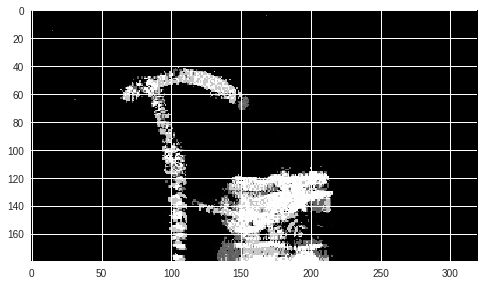

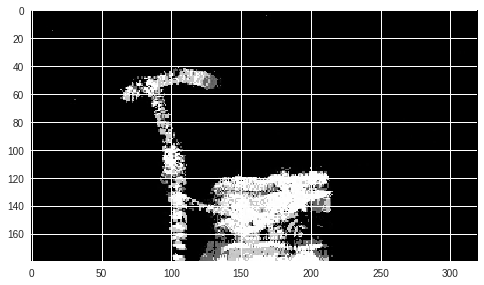

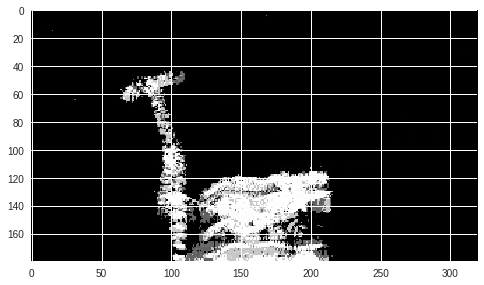

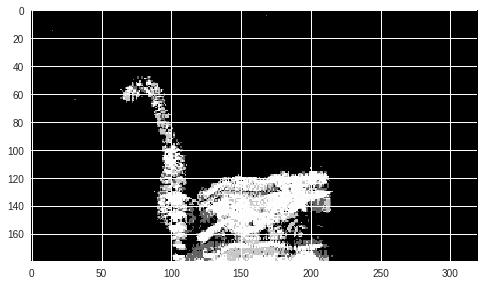

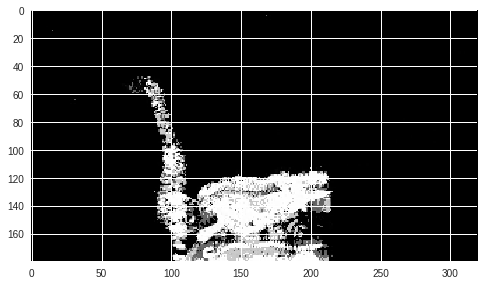

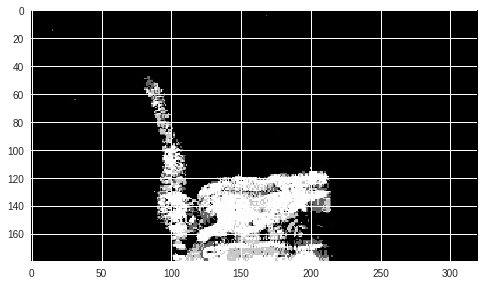

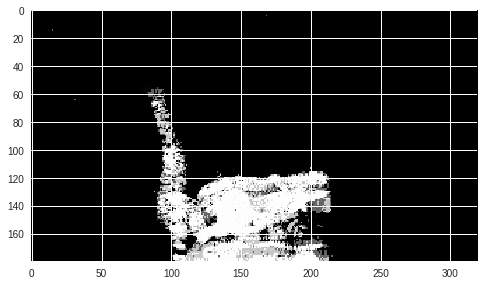

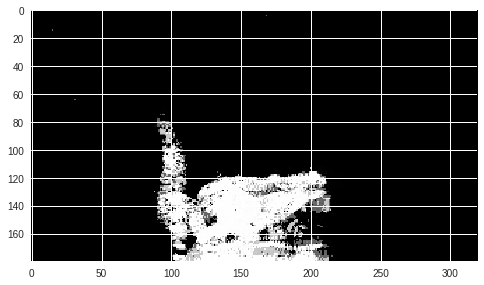

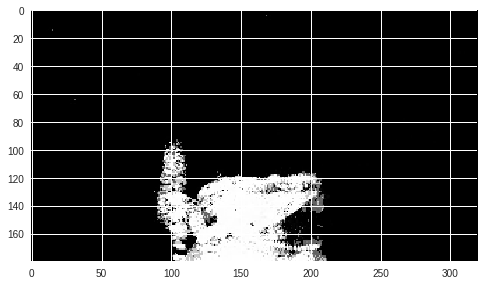

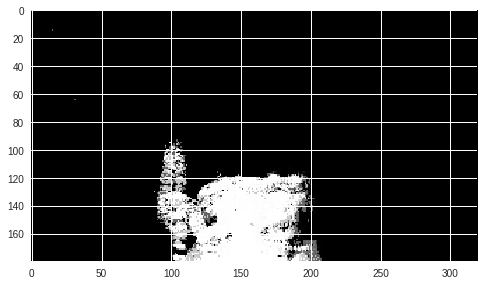

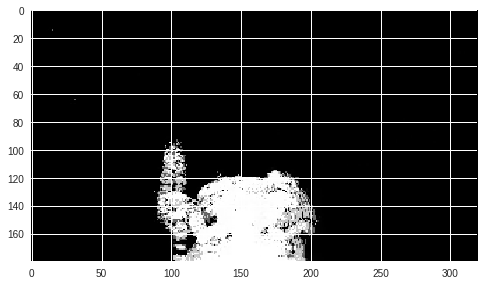

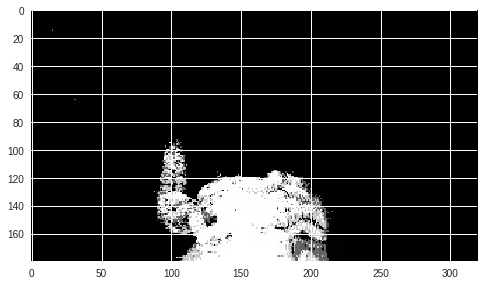

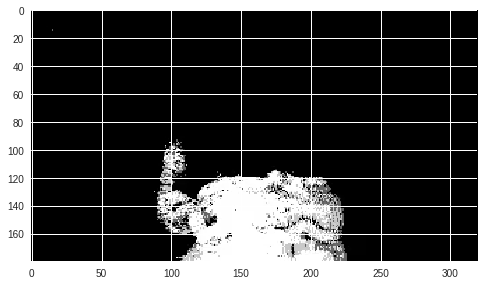

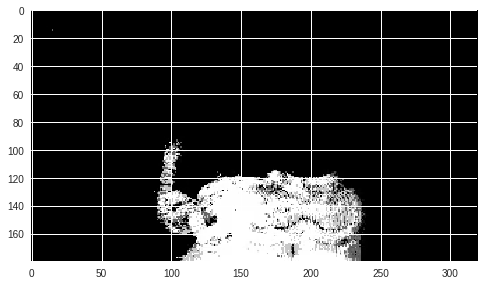

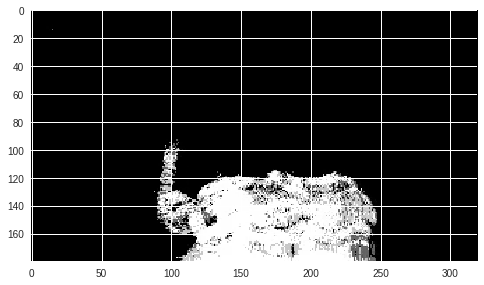

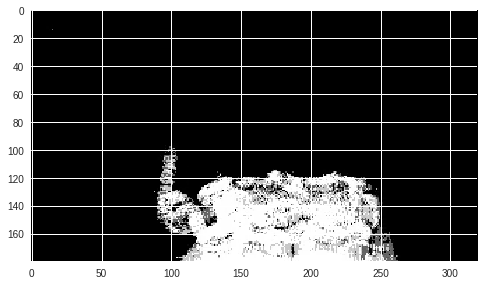

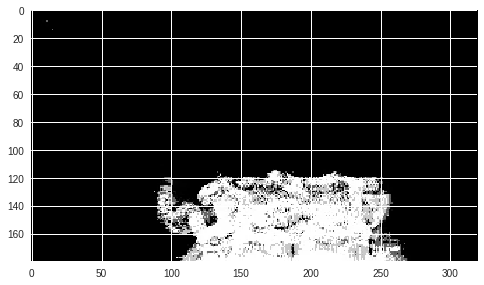

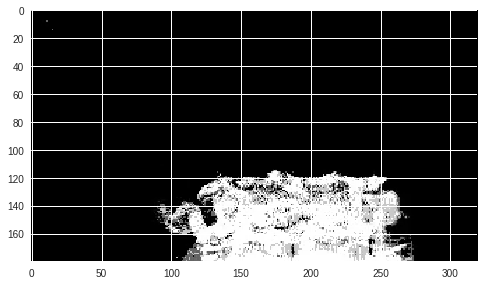

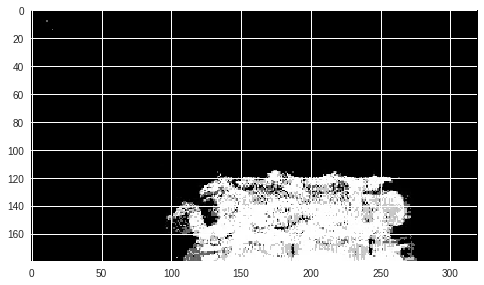

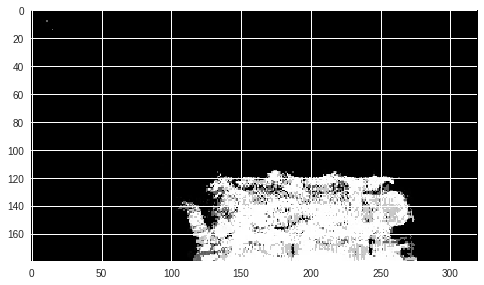

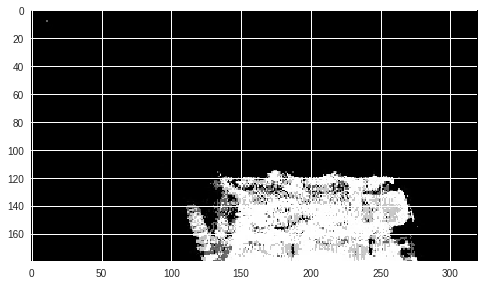

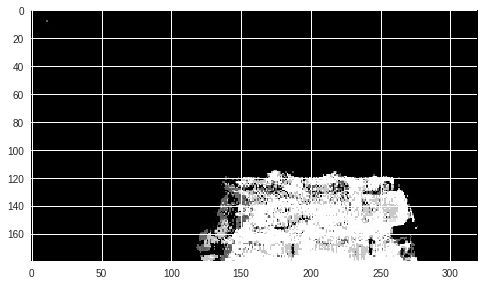

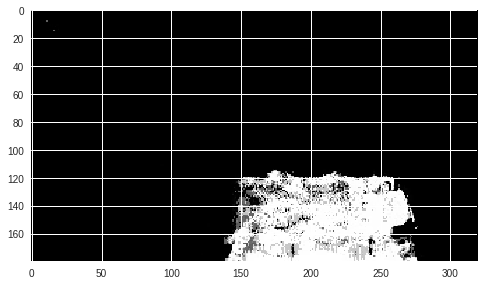

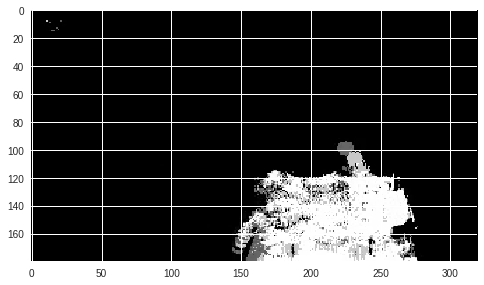

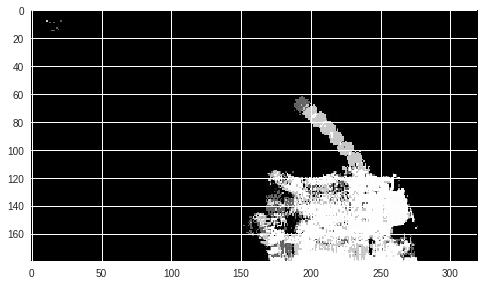

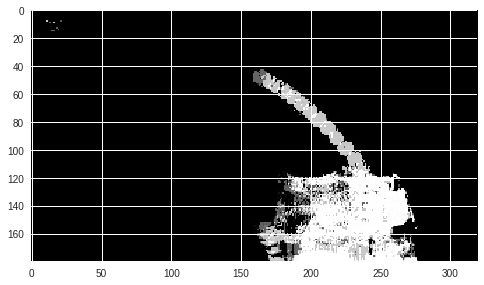

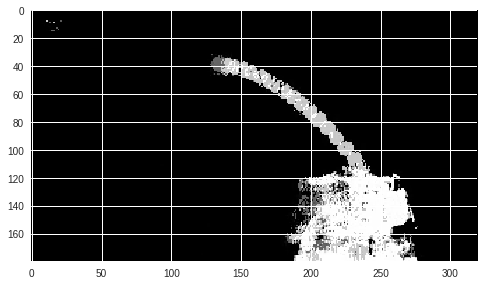

shootiing


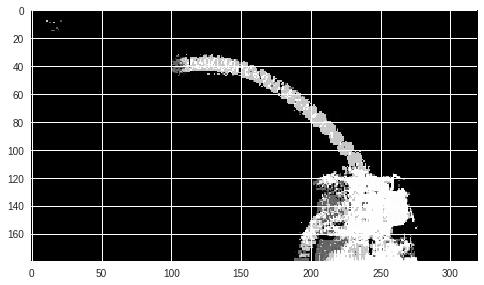

shootiing


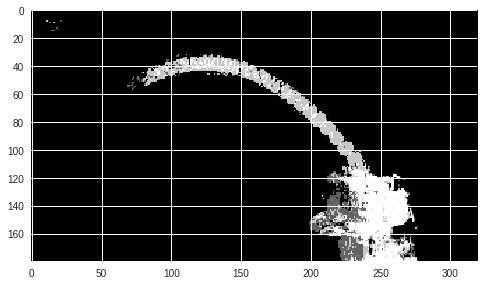

shootiing


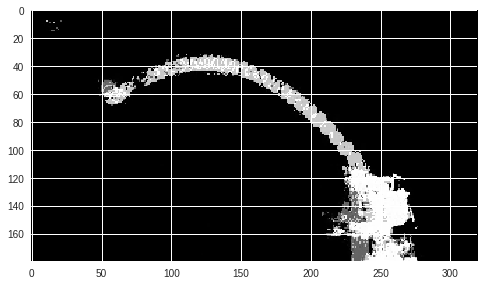

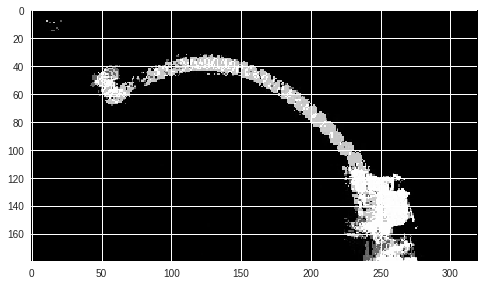

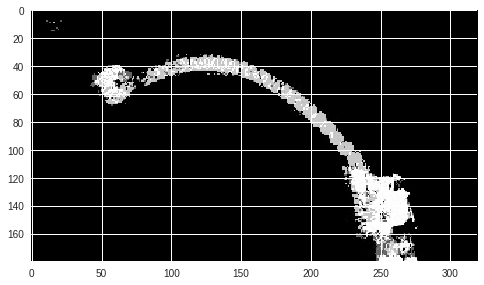

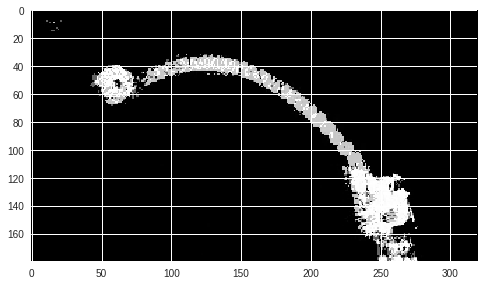

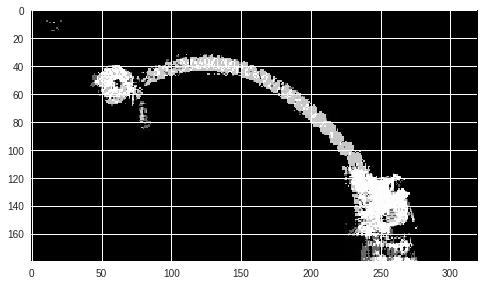

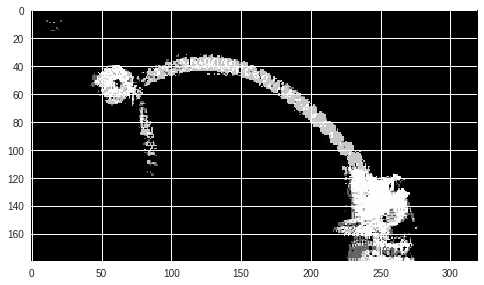

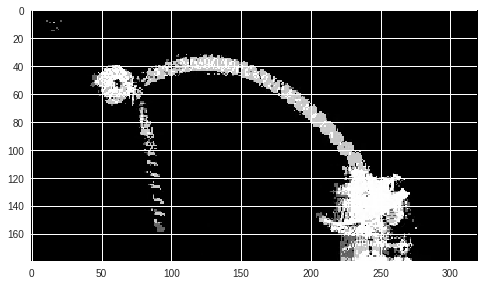

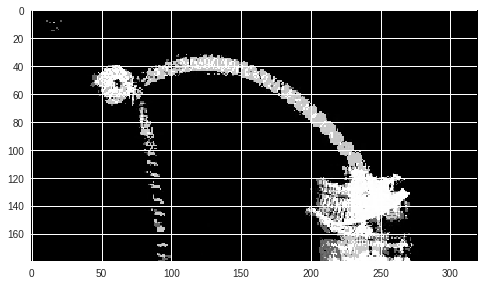

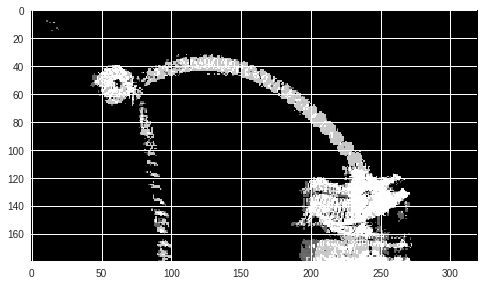

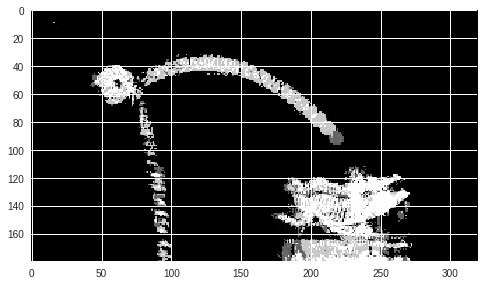

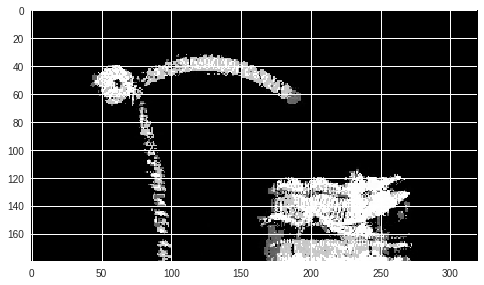

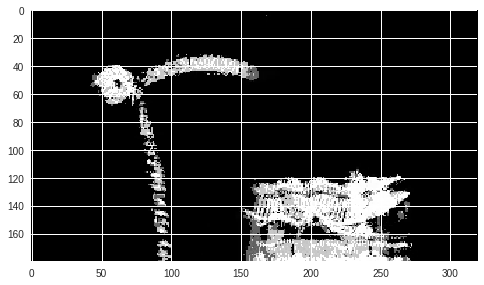

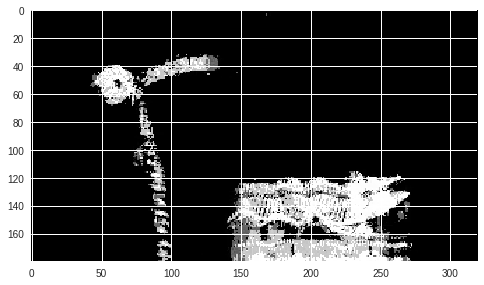

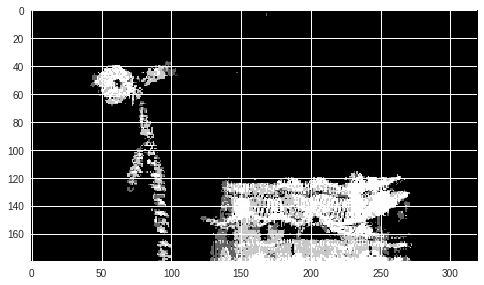

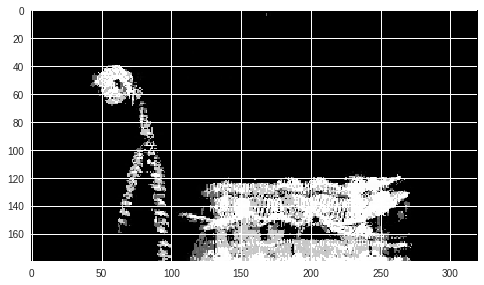

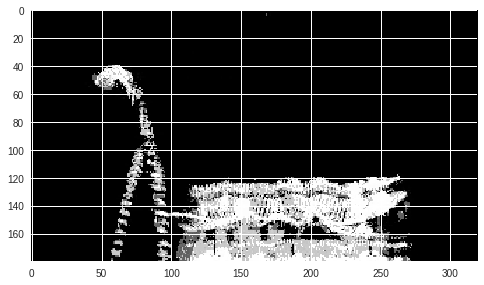

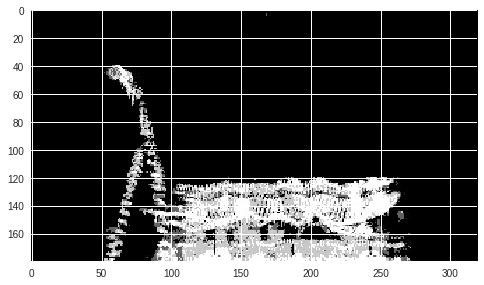

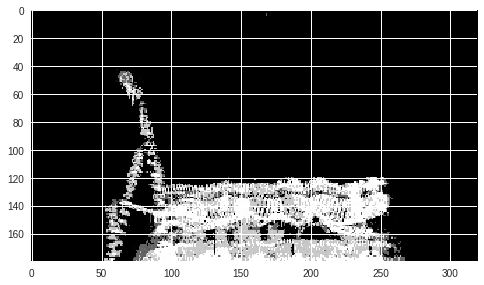

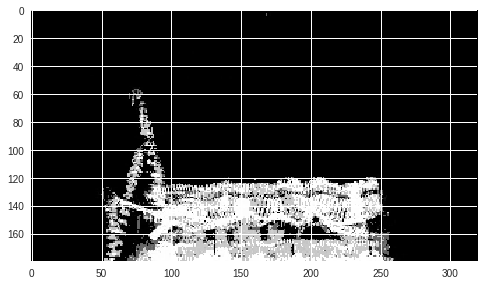

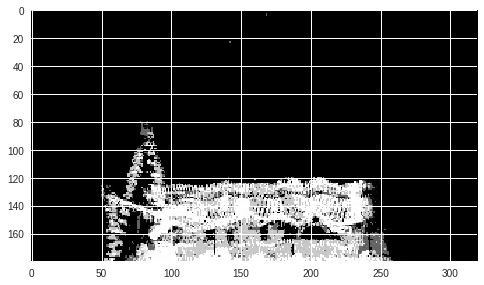

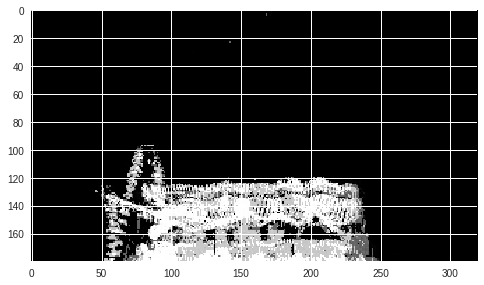

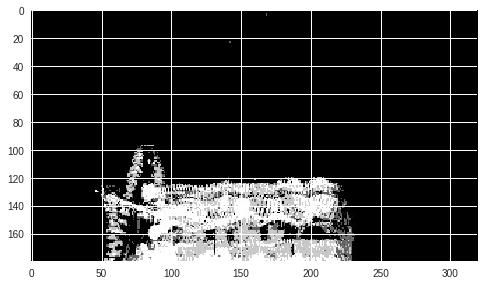

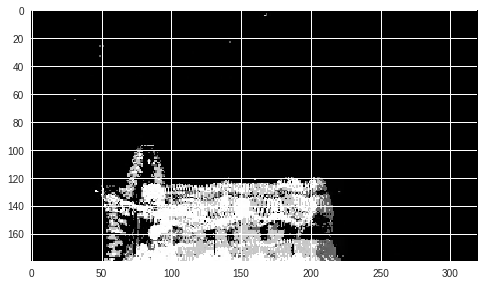

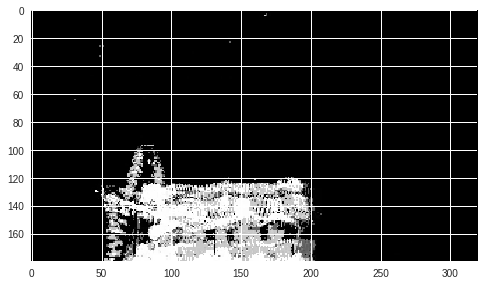

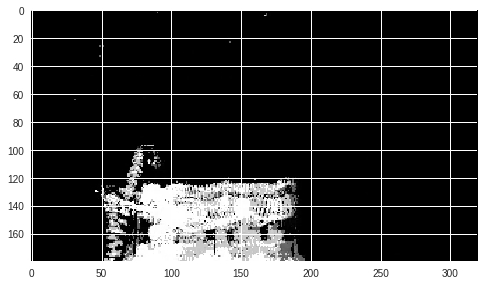

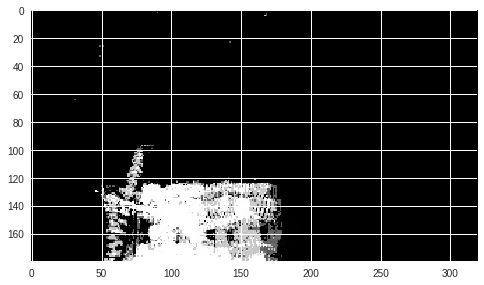

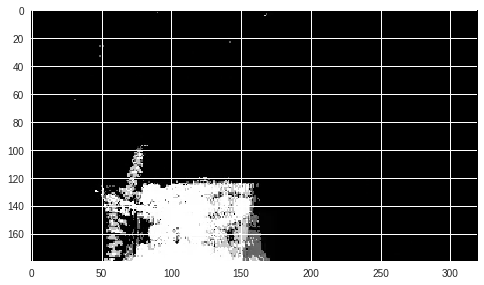

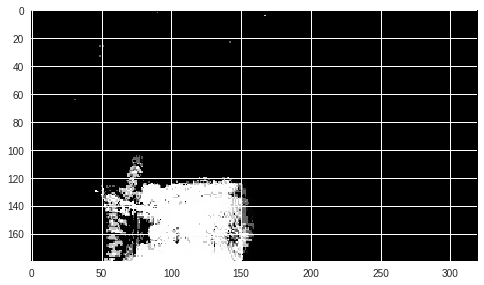

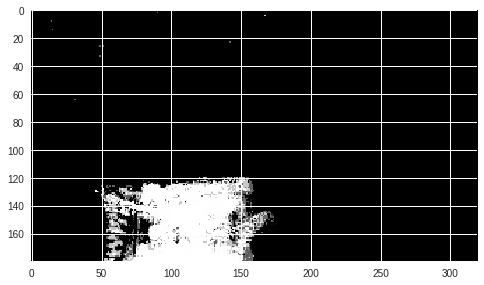

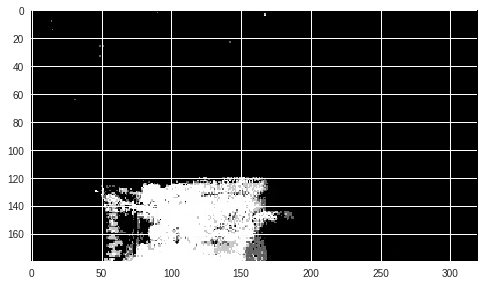

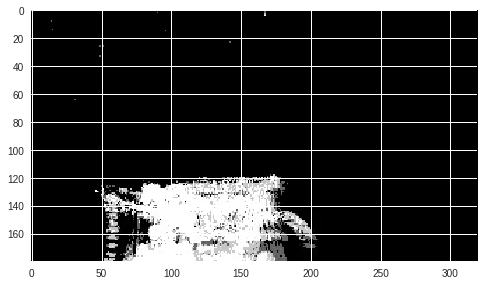

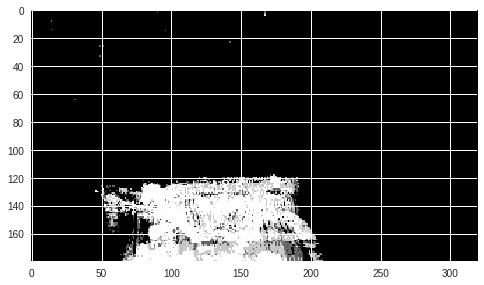

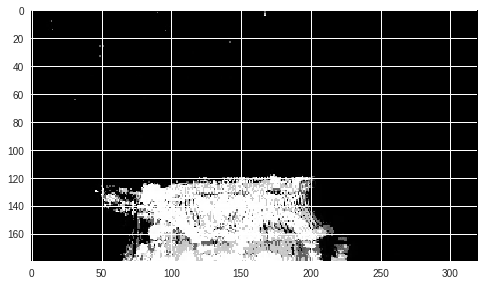

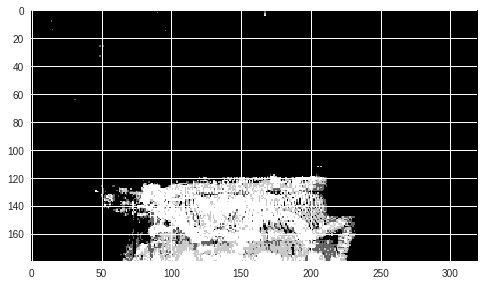

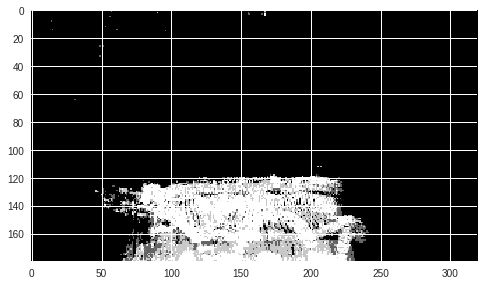

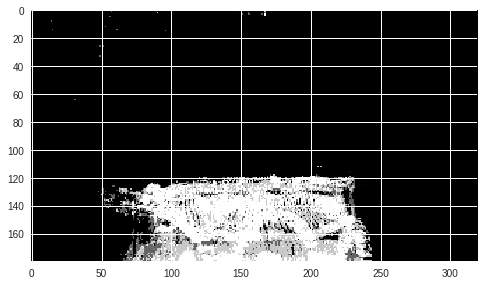

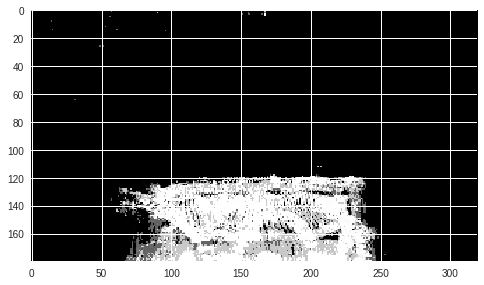

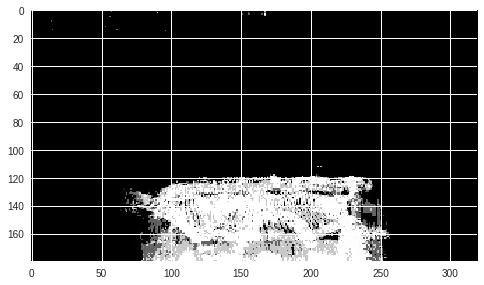

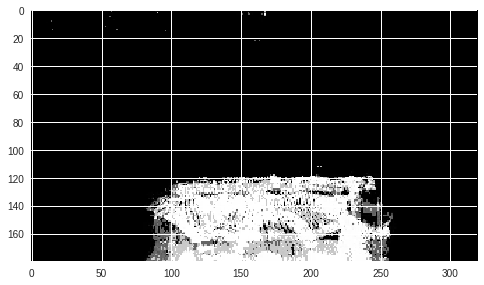

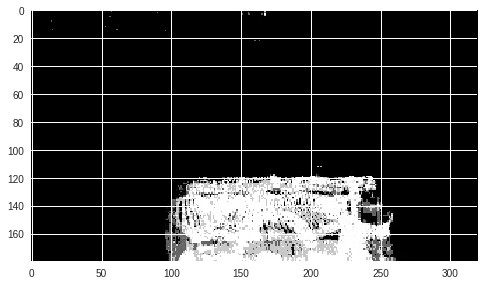

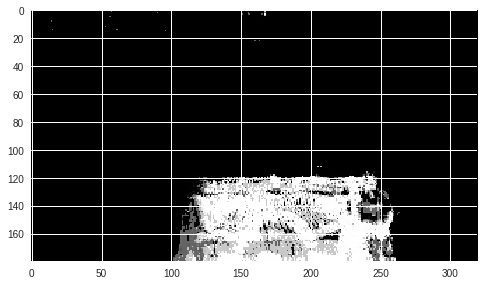

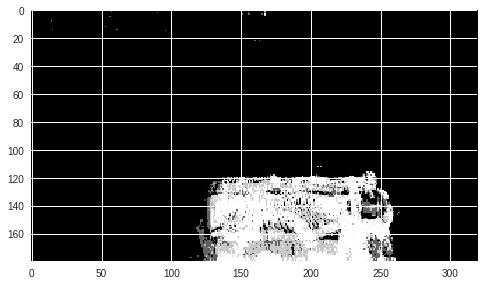

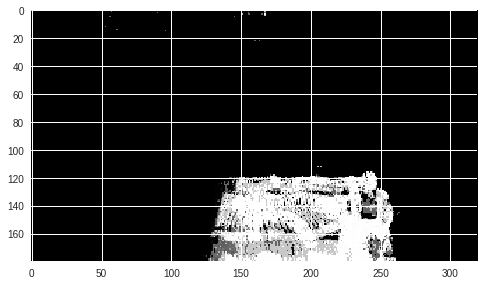

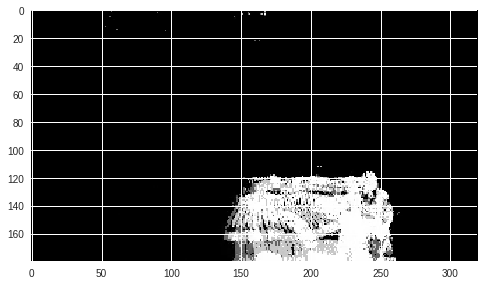

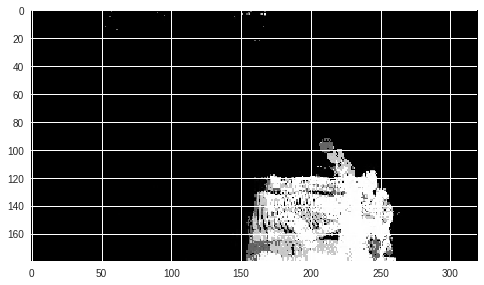

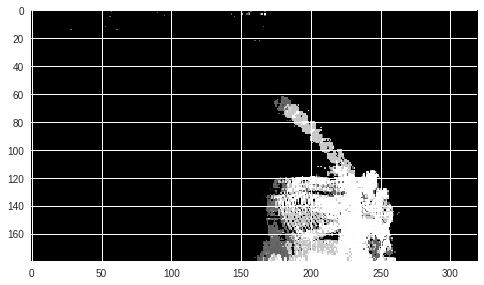

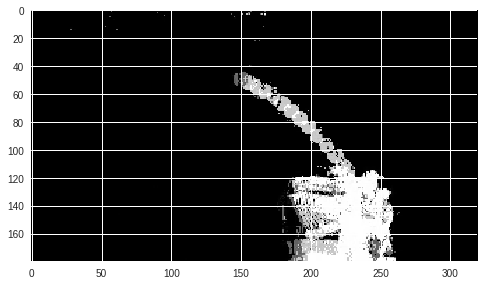

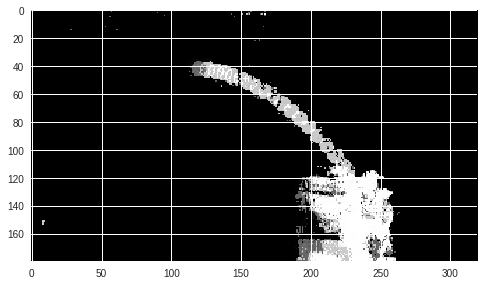

shootiing


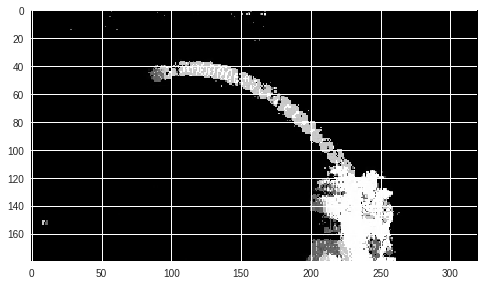

shootiing


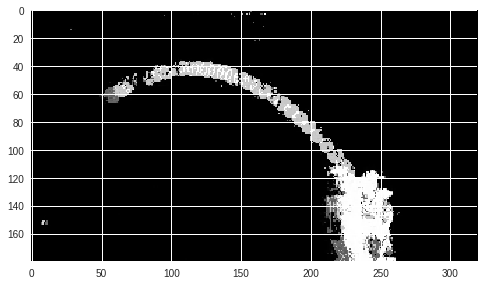

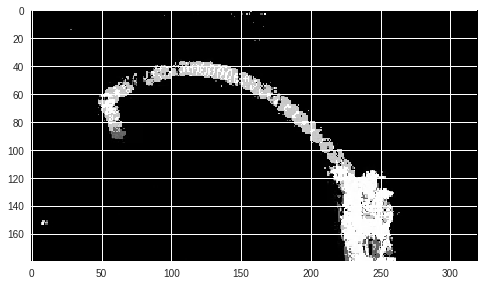

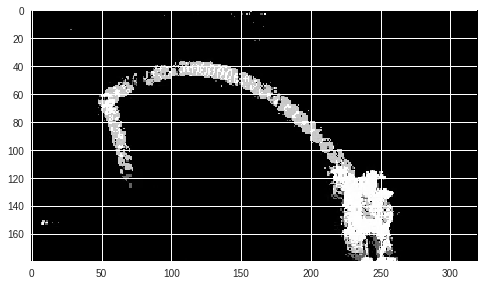

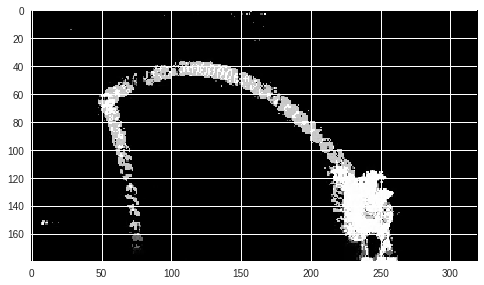

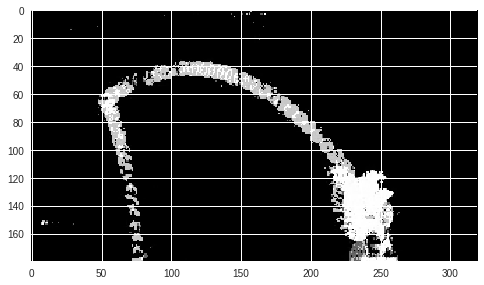

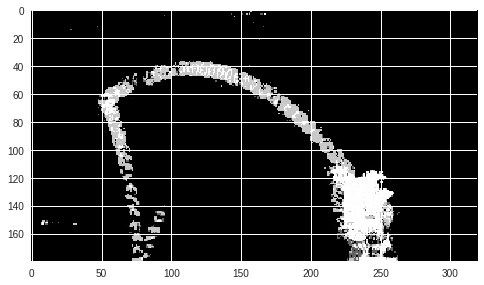

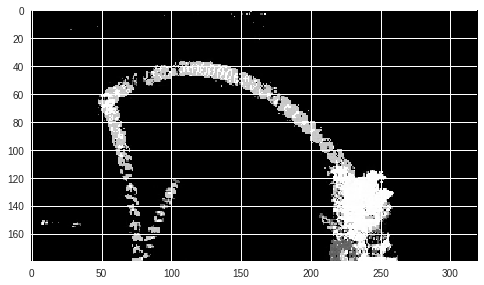

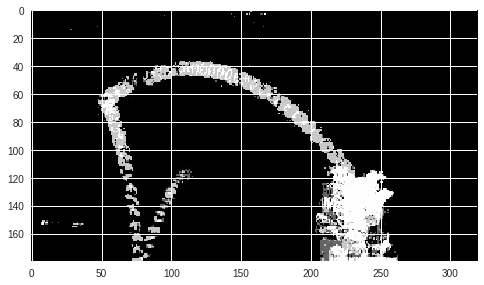

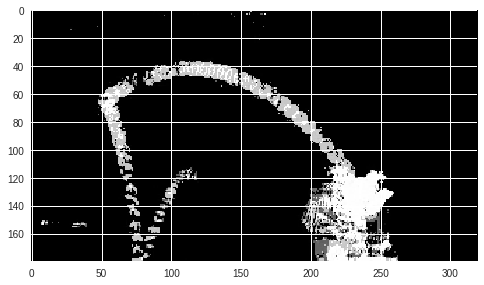

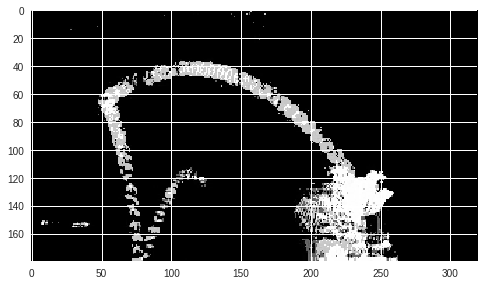

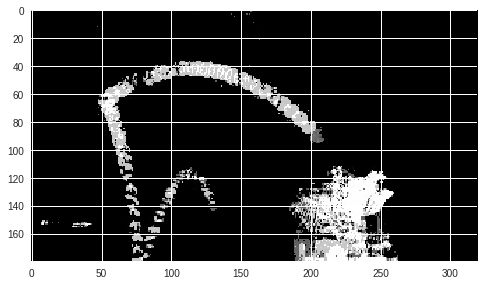

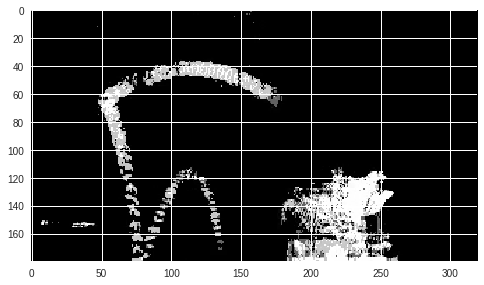

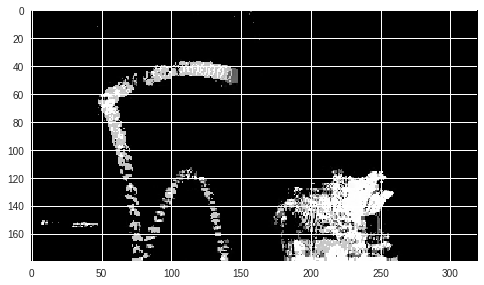

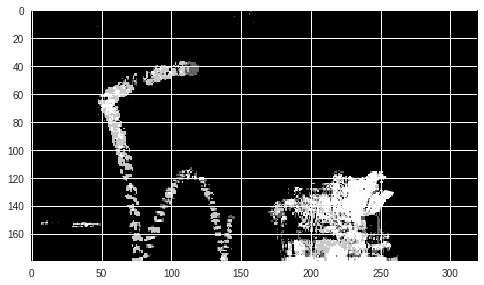

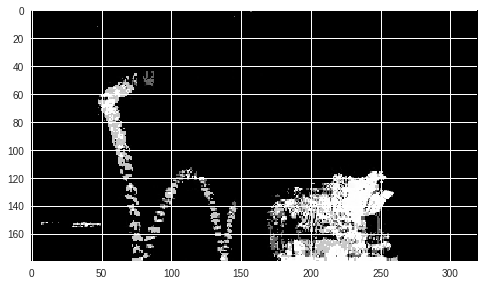

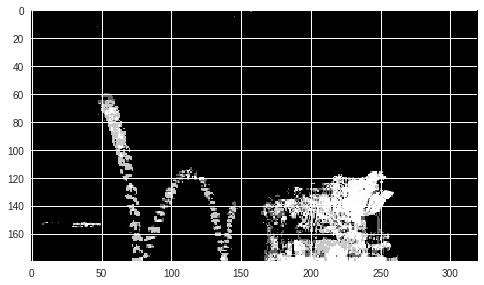

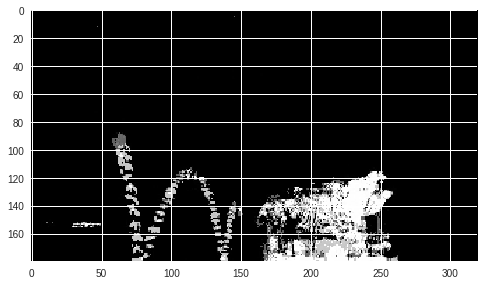

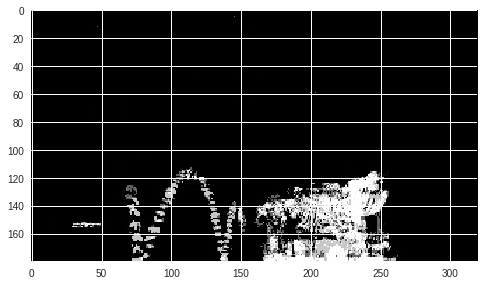

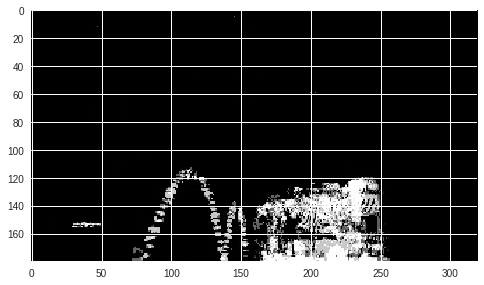

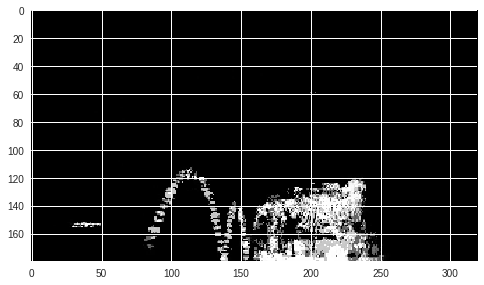

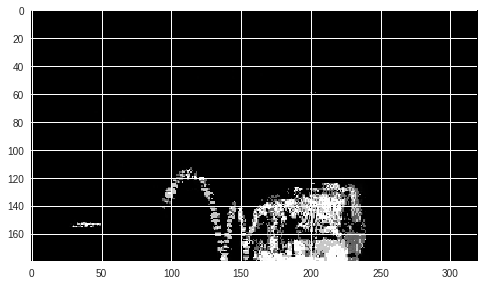

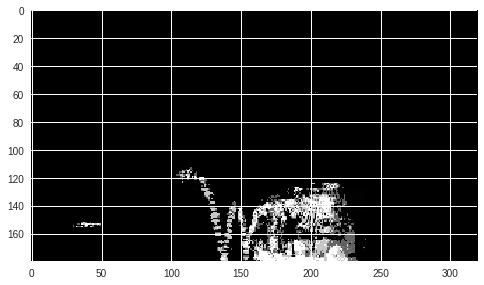

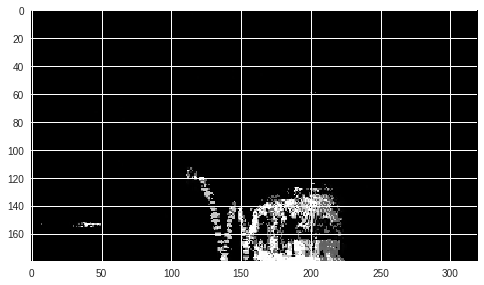

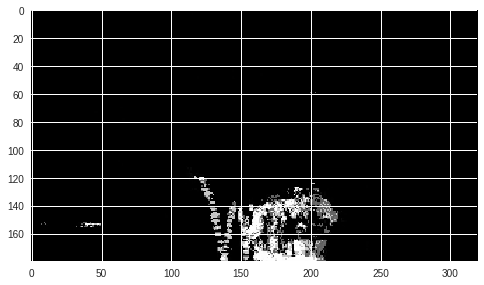

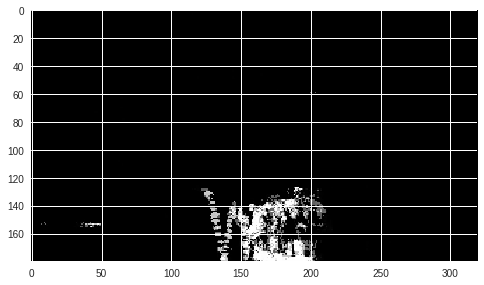

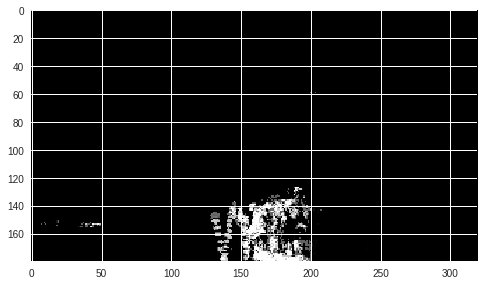

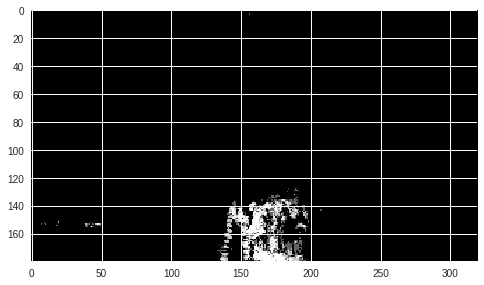

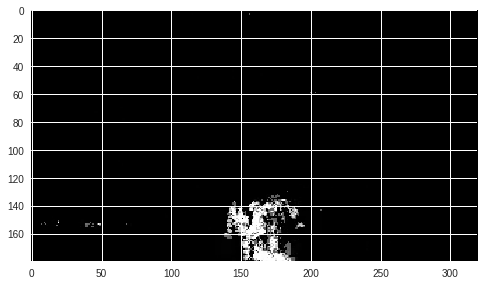

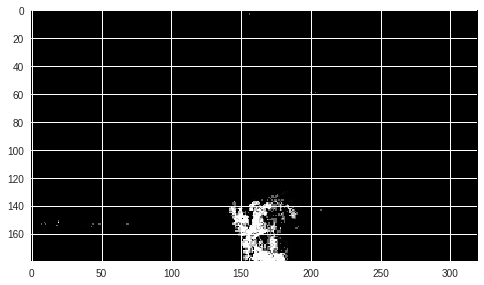

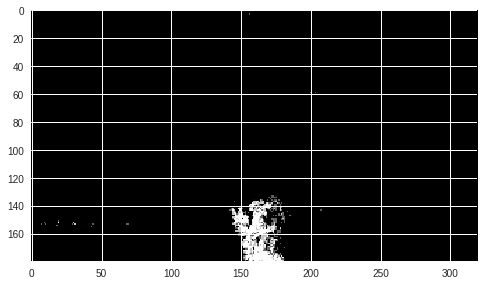

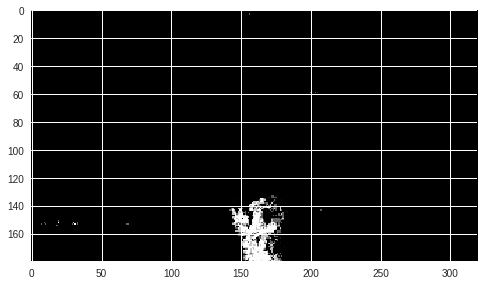

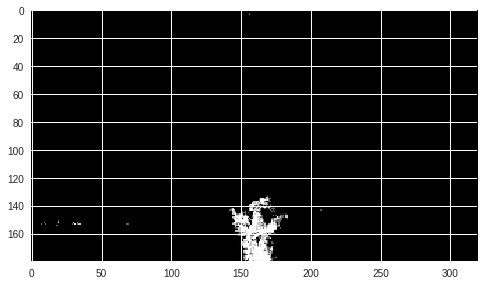

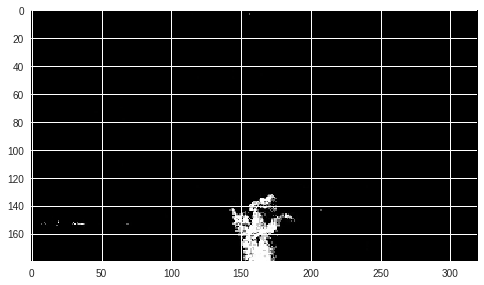

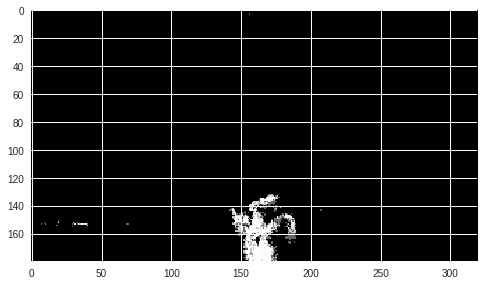

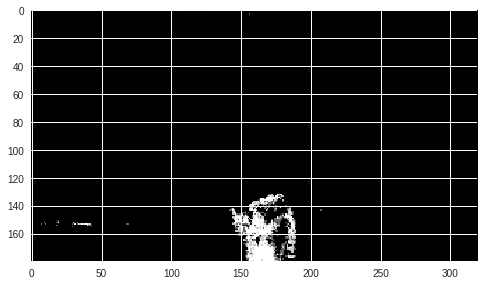

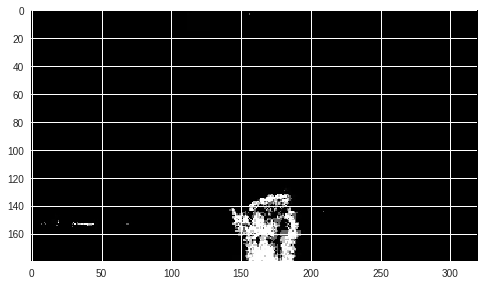

KeyboardInterrupt: ignored

In [0]:
for i in range(0, 2000, 5):
  frame = test[i:i+1]
  pred, = model.predict(frame)[0]
  if pred > 0.99:
    print('shootiing')
  
  plt.imshow(gray_to_channel(test[i]))
  plt.show()

In [0]:
test_data = vread('deltas.mp4')[7000:9000,:,:,0]
val_test = np.expand_dims(test_data, axis=3) / 255.

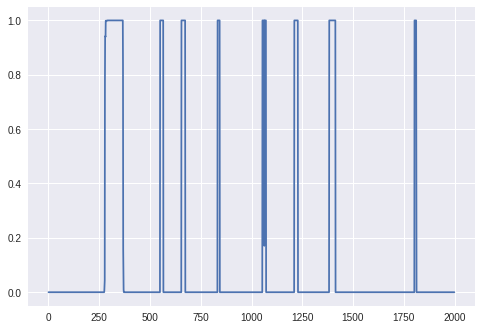

In [40]:
output = model.predict(val_test)
plt.plot(output)

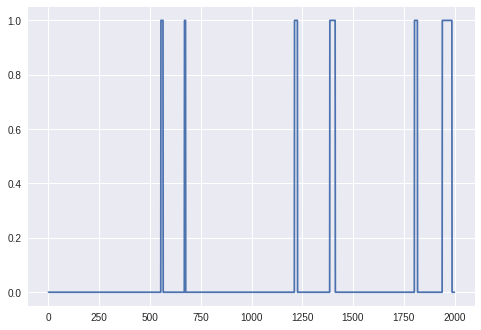

In [47]:
y_test_val = ~(np.array(ys['y']) == None)[7000:9000]
plt.plot(y_test_val)

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [43]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Saved model to disk


In [45]:
! gsutil cp model.h5 gs://rugby-videos/model.h5

Copying file://model.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/27.2 MiB.                                     


In [46]:
! gsutil cp model.json gs://rugby-videos/model.json

Copying file://model.json [Content-Type=application/json]...
/ [1 files][  2.8 KiB/  2.8 KiB]                                                
Operation completed over 1 objects/2.8 KiB.                                      


In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 178, 318, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 176, 316, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 158, 8)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 88, 158, 8)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 111232)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                7118912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

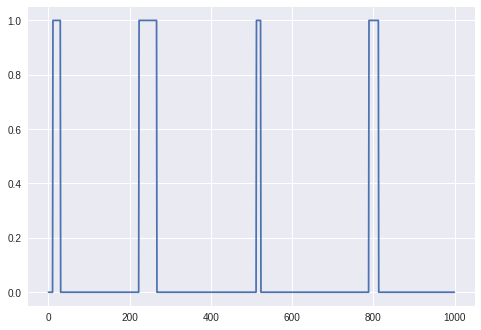

In [48]:
y_test_val = ~(np.array(ys['y']) == None)[-1000:]
plt.plot(y_test_val)